# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

- Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

- Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Inicialización Cargar librerias

In [1]:
import pandas as pd
import sklearn
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import catboost as cb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Cargamos datasets
vehicles = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Renombramos las columnas para que el código se vea más coherente con su estilo snake_case
vehicles = vehicles.rename(columns={
    'datetime': 'date_time'
})

# actualizar indice
vehicles.reset_index(drop=True, inplace=True)

In [4]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date_time   26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
vehicles.head()

,date_time,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
vehicles.shape

(26496, 2)

In [7]:
# Verifica si hay valores nulos
vehicles.isnull().sum()

date_time     0
num_orders    0
dtype: int64

In [8]:
# Verificamos que las columnas 
vehicles.columns

Index(['date_time', 'num_orders'], dtype='object')

In [9]:
# Verificamos los tipos de datos
vehicles.dtypes

date_time     object
num_orders     int64
dtype: object

In [10]:
# Verificamos que la columna num_orders sea del tipo objeto "float"
vehicles['num_orders'] = vehicles['num_orders'].astype(float)

In [11]:
# Verificamos que la columna de tiempo sea de tipo datetime
vehicles['date_time'] = pd.to_datetime(vehicles['date_time'])

In [12]:
# Verificamos los tipos de datos cambiados sea de tipo datatime
vehicles.dtypes

date_time     datetime64[ns]
num_orders           float64
dtype: object

In [13]:
# Contar duplicados explícitos
vehicles.duplicated().sum()

0

## Analisis

### Realiza el remuestreo por hora (60min)

In [14]:
# Utilizamos método resample para agrupar los datos por hora y calcular la media de las otras columnas.
# la columna de tiempo sea el índice del DataFrame:

date_time_resampled = vehicles.set_index('date_time').resample('1H').mean()

In [15]:
date_time_resampled.head(5)

,num_orders
date_time,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


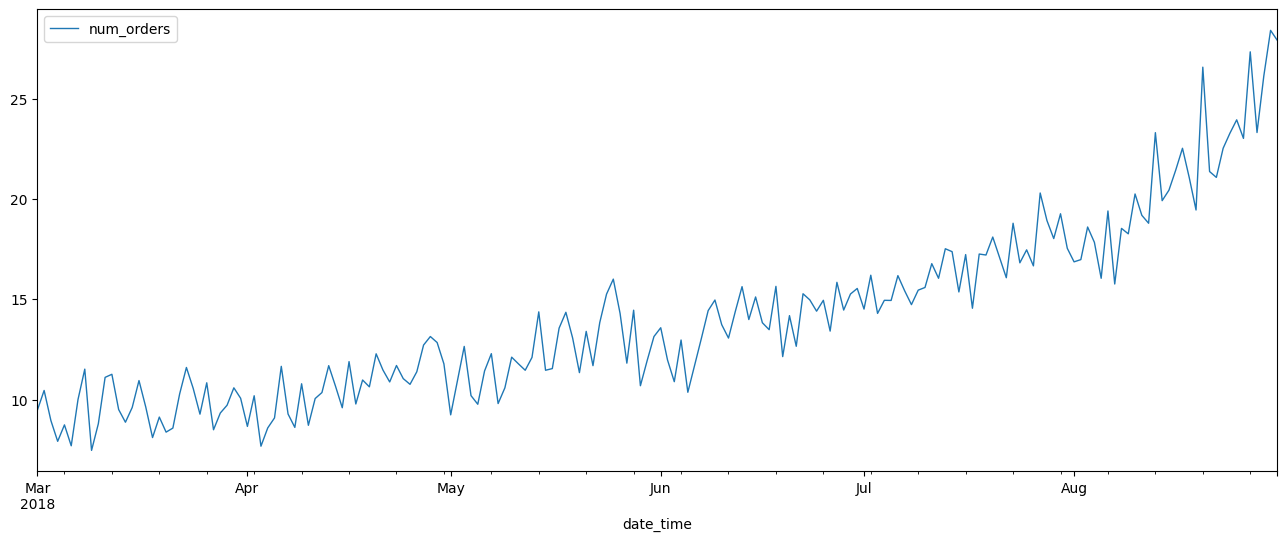

In [16]:
date_time_resampled.resample("1D").mean().plot(figsize=(16, 6), lw=1)
plt.show()

- Conclusion, tenemos un alza en los meses de julio a agosto se ven aumentados los numero de orndenes.

In [17]:
# Componentes de descoposición 
decomposed_series = seasonal_decompose(vehicles["num_orders"], period=365) # consideramos el periodo de un año

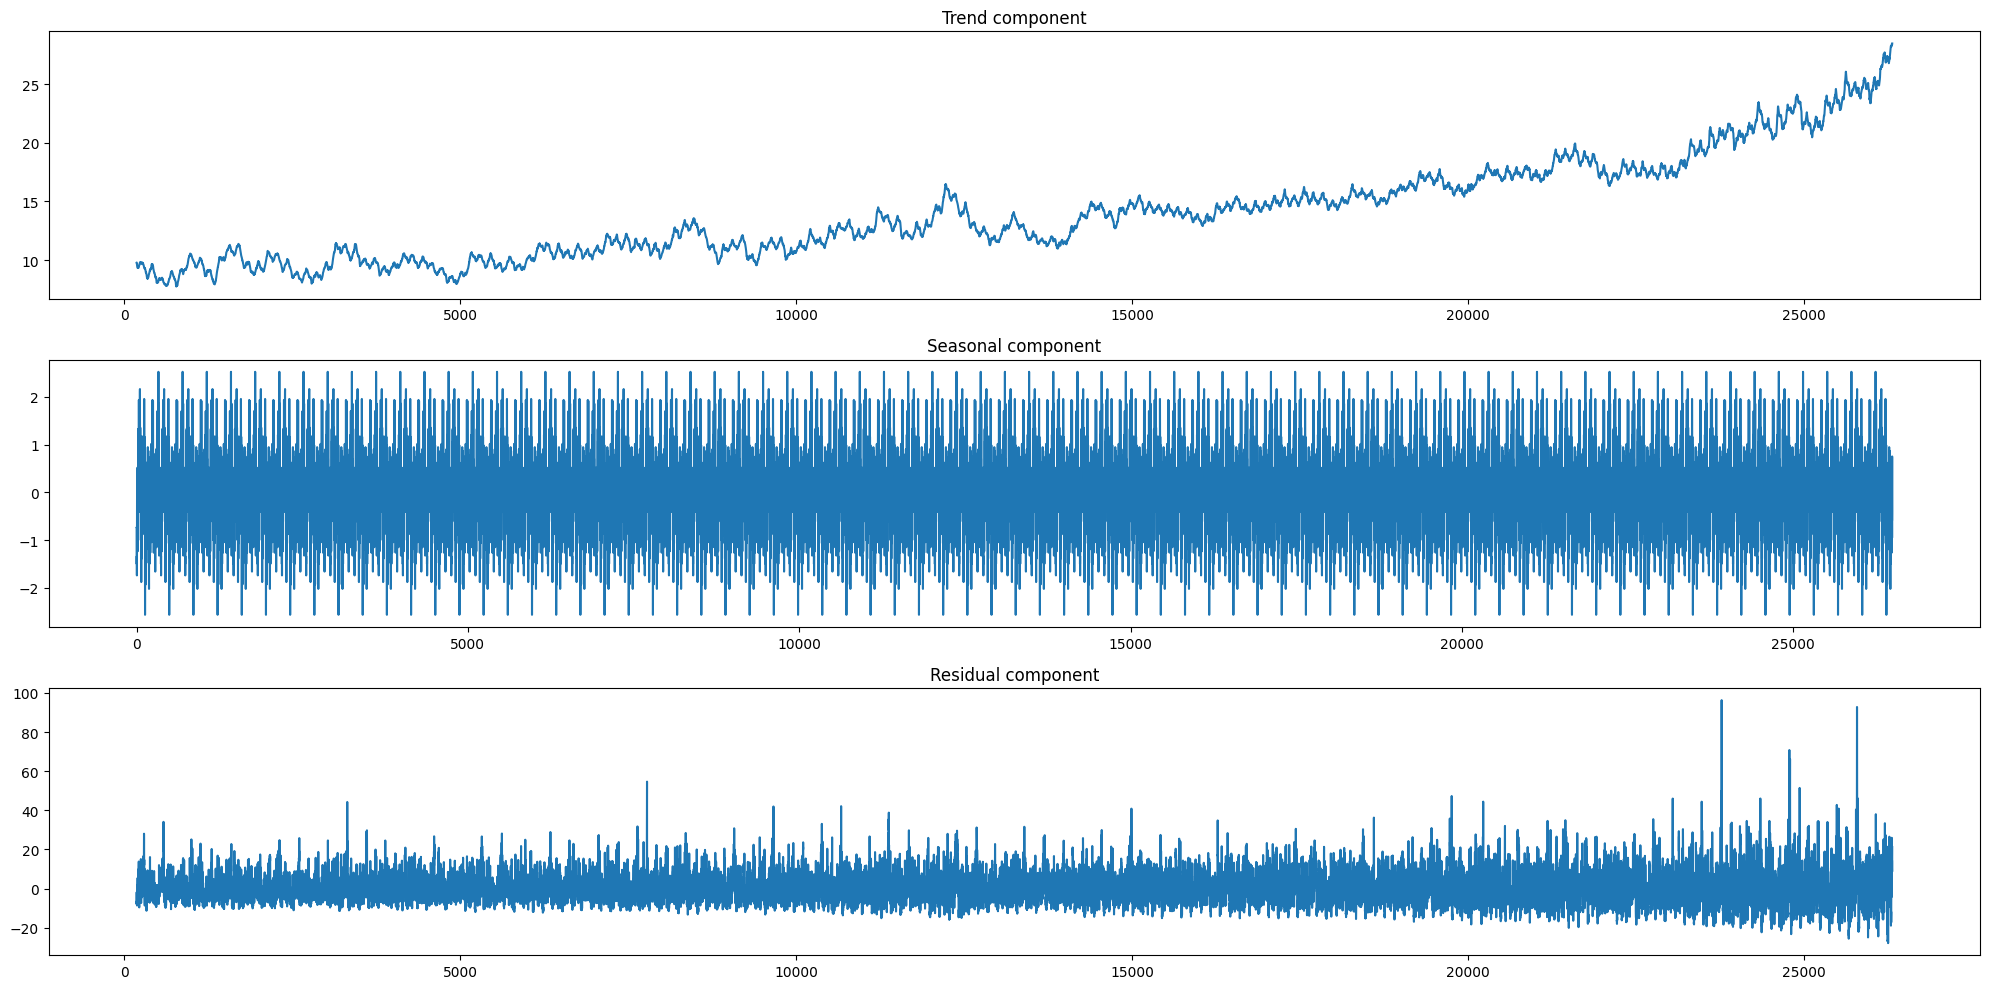

In [18]:
plt.figure(figsize=(20, 10))

plt.subplot(311)
decomposed_series.trend.plot(ax=plt.gca())
plt.title("Trend component") # componente de tendencia

plt.subplot(312)
decomposed_series.seasonal.plot(ax=plt.gca())
plt.title("Seasonal component") # componente de Estacional

plt.subplot(313)
decomposed_series.resid.plot(ax=plt.gca())
plt.title("Residual component") # componente de Residual

plt.tight_layout()

- conclusión, verificamos que tan importante es el factor estacional, la descomposición nos da el resultado de la suma de componentes de la serie original.

In [19]:
combined_series = decomposed_series.trend + decomposed_series.resid + decomposed_series.seasonal

In [20]:
combined_series[100:110]

100   NaN
101   NaN
102   NaN
103   NaN
104   NaN
105   NaN
106   NaN
107   NaN
108   NaN
109   NaN
dtype: float64

In [21]:
date_time_resampled[100:110]

,num_orders
date_time,
2018-03-05 04:00:00,5.666667
2018-03-05 05:00:00,2.666667
2018-03-05 06:00:00,0.500000
2018-03-05 07:00:00,2.333333
2018-03-05 08:00:00,5.166667
2018-03-05 09:00:00,9.833333
2018-03-05 10:00:00,8.333333
2018-03-05 11:00:00,10.333333
2018-03-05 12:00:00,14.166667


## Entrena diferentes modelos con diferentes hiperparámetros. 
    - La muestra de prueba debe ser el 10% del conjunto de datos 

In [22]:
vehicles["date_time"].head()

0   2018-03-01 00:00:00
1   2018-03-01 00:10:00
2   2018-03-01 00:20:00
3   2018-03-01 00:30:00
4   2018-03-01 00:40:00
Name: date_time, dtype: datetime64[ns]

In [23]:
vehicles["date_time"].shift(1).head()

0                   NaT
1   2018-03-01 00:00:00
2   2018-03-01 00:10:00
3   2018-03-01 00:20:00
4   2018-03-01 00:30:00
Name: date_time, dtype: datetime64[ns]

In [24]:
def make_features(df, lag_size=5, rolling_size=5):

  data_copy = df.copy() # data_copy = df.copy().to_frame()

  for i in range(lag_size):
    data_copy[f"num_orders{str(i+1)}"] = data_copy["num_orders"].shift(i+1)

  data_copy[f"num_orders"] = data_copy["num_orders"].shift(24)

  data_copy["rolling_mean"] = data_copy["num_orders"].shift(1).rolling(rolling_size).mean()
  data_copy["rolling_std"] = data_copy["num_orders"].shift(1).rolling(rolling_size).std()
  data_copy["rolling_max"] = data_copy["num_orders"].shift(1).rolling(rolling_size).max()
  data_copy["rolling_min"] = data_copy["num_orders"].shift(1).rolling(rolling_size).min()

  data_copy['num_orders'] = data_copy.index.dayofweek # dia de la semana

  return data_copy

In [25]:
df_with_features = make_features(date_time_resampled, lag_size=5, rolling_size=5)

In [26]:
# creamos el dataset
df_with_features.head()

,num_orders,num_orders1,num_orders2,num_orders3,num_orders4,num_orders5,rolling_mean,rolling_std,rolling_max,rolling_min
date_time,,,,,,,,,,
2018-03-01 00:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,3,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,3,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,3,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,3,11.000000,11.833333,14.166667,20.666667,NaN,NaN,NaN,NaN,NaN


In [27]:
# reiniciamos el dataset
clean_df_with_features = df_with_features.dropna()

In [28]:
# Data set limpio
clean_df_with_features.head(2)

,num_orders,num_orders1,num_orders2,num_orders3,num_orders4,num_orders5,rolling_mean,rolling_std,rolling_max,rolling_min
date_time,,,,,,,,,,
2018-03-02 05:00:00,4,3.333333,10.666667,12.500000,20.0,15.0,12.966667,4.988041,20.666667,7.166667
2018-03-02 06:00:00,4,1.833333,3.333333,10.666667,12.5,20.0,9.033333,5.149703,14.166667,1.000000


In [29]:
# Verificar la versión de la libreria
sklearn.__version__

'0.24.1'

In [30]:
# anterior revisar
# Dividir los datos en conjuntos de entrenamiento y prueba (90% entrenamiento, 10% prueba)
# Separa utilizando train_test_split.

# train_df, test_df = train_test_split(
#     vehicles, 
#     test_size = 0.1,
#     random_state = 88
# )

In [31]:
# Dividir los datos en conjuntos de entrenamiento y prueba (90% entrenamiento, 10% prueba)

train_set, test_set = train_test_split(clean_df_with_features, shuffle=False, test_size=0.1)
reduced_train_set, valid_set = train_test_split(train_set, shuffle=False, test_size=0.1)

len(test_set) / (len(train_set) + len(test_set))

0.1000683838614087

In [32]:
# Definir el target 
target = "num_orders"
features = [c for c in train_set.columns if c != target]

In [33]:
# LinealRegression, RandomForest, LightGBMRegressor, XGBoostRegressor, SVRegressor, LSTM (RNN)

### Modelo DecisionTreeRegressor

In [34]:
# max_depth_space = list(np.linspace(1, 20, 11).astype("int"))
# max_depth_space.append(None)

# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error

for i, criteria in enumerate(["mse", "friedman_mse", "mae", "poisson"]):
    model = DecisionTreeRegressor(criterion=criteria, random_state=i + 100)
    model.fit(reduced_train_set[features], reduced_train_set[target])

    preds = model.predict(valid_set[features])

    print(f"""
    Criterio: {criteria}
    RMSE: {mean_squared_error(valid_set[target], preds)**0.5}
    """)

# squared_error : mse
# absolute_error : mae
        


    Criterio: mse
    RMSE: 2.6553027909058518
    

    Criterio: friedman_mse
    RMSE: 2.6294341692905934
    

    Criterio: mae
    RMSE: 2.9161271351493627
    

    Criterio: poisson
    RMSE: 2.791050708404254
    


In [35]:
best_criteria = "poisson"

best_model = DecisionTreeRegressor(criterion=best_criteria, random_state=200)
best_model.fit(train_set[features], train_set[target])

best_preds = best_model.predict(test_set[features])

In [36]:
print(f"""
Criteria: {best_criteria}
RMSE: {mean_squared_error(test_set[target], best_preds)**0.5}
""")


Criteria: poisson
RMSE: 2.9646229139245754



In [37]:
series_preds = pd.DataFrame(data={
    "prediction": best_preds,
    "target": test_set[target],
}, index=test_set.index)

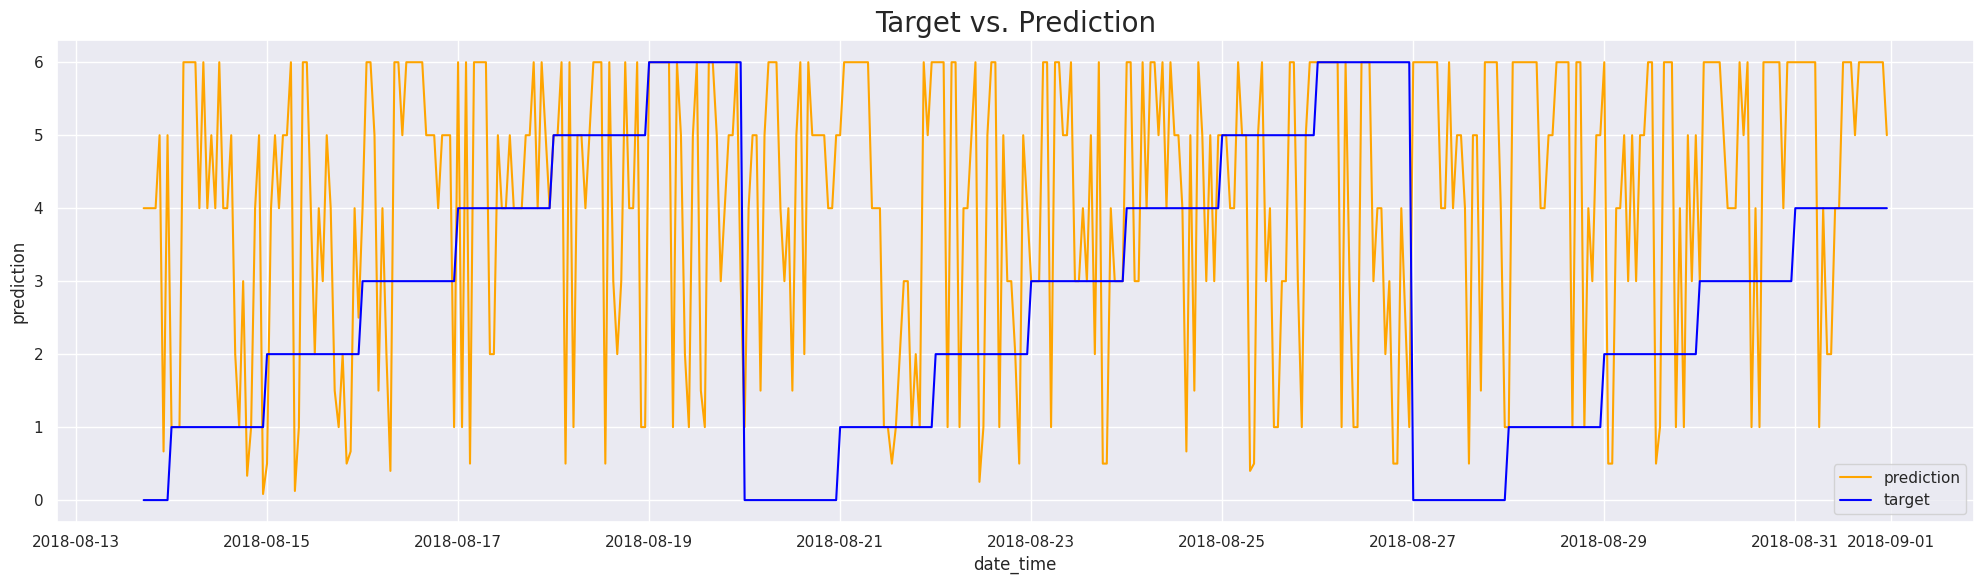

In [38]:
# Graficamos los resultados 

sns.set_theme()

plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds, x=series_preds.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds, x=series_preds.index, y="target", label="target", color="blue")
plt.title("Target vs. Prediction", size=20)
plt.tight_layout()

    Conclusión En el gráfico, puedes ver dos líneas: 
- una en color naranja que representa las predicciones. Muestra cómo se comparan tus predicciones con los valores reales a lo largo del tiempo.
- otra en azul que representa los valores reales (objetivos). 

    Algunas observaciones clave podrían ser:

    - Si la línea naranja sigue de cerca la línea azul, significa que tus predicciones son precisas y están en línea con los valores reales.
   - Si la línea naranja se desvía significativamente de la línea azul, podría indicar que tus predicciones no son tan precisas y que hay margen de mejora.

In [39]:
# verificamos el performance por meses y semanas 
series_preds["month"] = pd.to_datetime(series_preds.index) # Agrupamos por mes
series_preds["month"] = series_preds["month"].dt.to_period("M").dt.start_time

series_preds["week"] = pd.to_datetime(series_preds.index) # Agrupamos por semana
series_preds["week"] = series_preds["week"].dt.to_period("W-MON").dt.start_time

rmses = []
periods = []
granularity = "week"

for g in series_preds[granularity].unique():

  tmp_data = series_preds[series_preds[granularity] == g]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  periods.append(g)

performance_over_time = pd.DataFrame(data={
    granularity: periods,
    "rmse": rmses
})

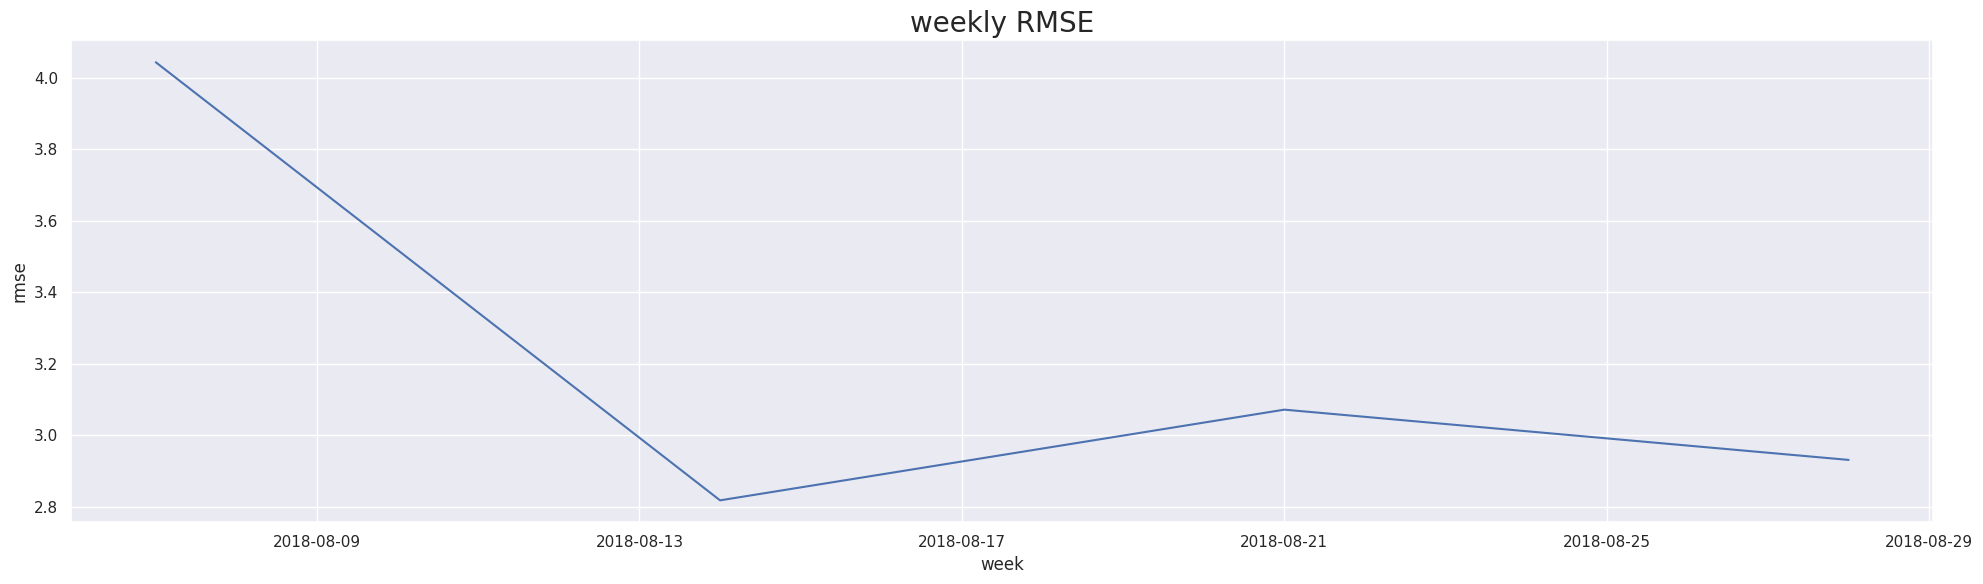

In [40]:
# Graficamos el desempeño a través del tiempo 
plt.figure(figsize=(20, 6))
sns.lineplot(data=performance_over_time, x=granularity, y="rmse")
plt.title(f"{granularity}ly RMSE", size=20)
plt.tight_layout()

Conclusión,  el grafico muestra el error cuadrático medio (RMSE) a lo largo del tiempo, con respecto a la granularidad (por ejemplo, diariamente, semanalmente o mensualmente). 
Aquí está la conclusión basada en el gráfico:

- Si la línea del RMSE es constante o disminuye a lo largo del tiempo, significa que tu modelo está mejorando o al menos manteniendo su rendimiento.
- Si la línea del RMSE aumenta a lo largo del tiempo, podría indicar que tu modelo está empeorando o que hay algún problema en los datos o en el proceso de entrenamiento.

### Modelo CatBoostRegressor

In [41]:
# Verificamos la versión y la documentación 
cb.__version__

'1.0.3'

In [42]:
%%time

# Ajustar el modelo
model_cb = cb.CatBoostRegressor(loss_function='RMSE', iterations=50)
model_cb.fit(train_set.drop(columns=['num_orders']), train_set['num_orders'])

# Utilizar test_df para la predicción
preds_cb = model_cb.predict(test_set.drop(columns = 'num_orders'))

# Calcular el error cuadratico medio, calcular cuadrada y redondeado a 4 decimales
print(f"""
RMSE_Catboost performance:
{round(mean_squared_error(test_set['num_orders'], preds_cb)**0.5, 4)}
""")

Learning rate set to 0.5
0:	learn: 1.9724801	total: 50.1ms	remaining: 2.45s
1:	learn: 1.9572410	total: 53.4ms	remaining: 1.28s
2:	learn: 1.9450486	total: 56.8ms	remaining: 890ms
3:	learn: 1.9350053	total: 60.2ms	remaining: 693ms
4:	learn: 1.9223734	total: 63.7ms	remaining: 573ms
5:	learn: 1.9180278	total: 67ms	remaining: 491ms
6:	learn: 1.9146673	total: 70.5ms	remaining: 433ms
7:	learn: 1.9080955	total: 73.9ms	remaining: 388ms
8:	learn: 1.9001252	total: 77.3ms	remaining: 352ms
9:	learn: 1.8875234	total: 80.9ms	remaining: 324ms
10:	learn: 1.8785481	total: 84.4ms	remaining: 299ms
11:	learn: 1.8733343	total: 87.9ms	remaining: 278ms
12:	learn: 1.8682415	total: 91.3ms	remaining: 260ms
13:	learn: 1.8602652	total: 95.2ms	remaining: 245ms
14:	learn: 1.8560080	total: 99ms	remaining: 231ms
15:	learn: 1.8427799	total: 102ms	remaining: 218ms
16:	learn: 1.8340087	total: 106ms	remaining: 206ms
17:	learn: 1.8288547	total: 110ms	remaining: 195ms
18:	learn: 1.8242612	total: 113ms	remaining: 185ms
19:	l

### Modelo RandomForestRegressor

In [43]:
%%time

# Modelo de Random Forest
model_rf = RandomForestRegressor(random_state=88)
model_rf.fit(train_set.drop(columns = 'num_orders'), train_set['num_orders'])  

# utilizamos test_df para la predicción 
preds_rf = model_rf.predict(test_set.drop(columns = 'num_orders'))

# Calcular el error cuadratico medio, calcular cuadrada y redondeado a 4 decimales
print(f"""
RMSE_RandomForestRegressor:
{round(mean_squared_error(test_set['num_orders'], preds_rf)**0.5, 4)}
""")


RMSE_RandomForestRegressor:
2.0671

CPU times: user 3.05 s, sys: 7.77 ms, total: 3.05 s
Wall time: 3.06 s


### Modelo LinearRegression

In [44]:
# Supongamos que tienes un DataFrame llamado 'df' con una columna 'fecha' de tipo datetime64
# Vamos a convertir la columna 'fecha' a valores numéricos (días desde una fecha de referencia)
vehicles['date_time_numerical'] = (vehicles['date_time'] - pd.to_datetime('1970-01-01')).dt.total_seconds() / (24 * 60 * 60)

# Ahora puedes convertir la columna 'fecha_numerica' a tipo float64
vehicles['date_time_numerical'] = vehicles['date_time_numerical'].astype(float)

# Verifica que la conversión haya sido exitosa
print(vehicles.dtypes)


date_time              datetime64[ns]
num_orders                    float64
date_time_numerical           float64
dtype: object


In [45]:
%%time

# Ajustar el modelo
model_lr = LinearRegression()
model_lr.fit(train_set.drop(columns=['num_orders']), train_set['num_orders'])

# Utilizar test_df para la predicción
preds_lr = model_lr.predict(test_set.drop(columns = 'num_orders'))

# Calcular el error cuadrático medio, calcular raíz cuadrada y redondear a 4 decimales
rmse_lr = round(mean_squared_error(test_set['num_orders'], preds_lr) ** 0.5, 4)
print(f"RMSE_LinearRegression:\n{rmse_lr}")

RMSE_LinearRegression:
2.0036
CPU times: user 7.75 ms, sys: 12.5 ms, total: 20.2 ms
Wall time: 41.7 ms


## Prueba

### Conclusiones
- CatBoostRegressor: Tiene el RMSE más bajo (2.2691), lo que sugiere que es el modelo más preciso en tu conjunto.
- RandomForestRegressor: Aunque su RMSE (2.0671) es mejor que el DecisionTreeRegressor, aún está por encima del CatBoost.
- LinearRegression: Tiene el RMSE más bajo de todos (2.0036), lo que indica que es un buen modelo lineal.


### RMSE_DecisionTreeRegressor:  2.655
        
### RMSE_Catboost performance: 2.2691      

### RMSE_RandomForestRegressor: 2.0671

### RMSE_LinearRegression: 2.0036


# Lista de revisión

- [x]  Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48